In [76]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
import warnings
warnings.filterwarnings('ignore')

In [77]:
url='https://docs.google.com/spreadsheets/d/1G4gkQ5B5t438LP19-rDV5SsPOWPoG2hBucZFfVb_XDI/export?format=csv&gid=644434020'
df=pd.read_csv(url)
df.head()

,TransactionID,Amount,Time,Location,MerchantCategory,CardHolderAge,IsFraud
0,1,375.17,47605,Houston,Travel,18.0,0
1,2,950.76,38088,Los Angeles,Electronics,28.0,0
2,3,732.26,78752,Miami,Travel,20.0,0
3,4,599.06,55284,New York,Groceries,69.0,0
4,5,156.86,57043,New York,Groceries,79.0,0


In [78]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   TransactionID     500 non-null    int64  
 1   Amount            475 non-null    float64
 2   Time              500 non-null    int64  
 3   Location          475 non-null    object 
 4   MerchantCategory  500 non-null    object 
 5   CardHolderAge     476 non-null    float64
 6   IsFraud           500 non-null    int64  
dtypes: float64(2), int64(3), object(2)
memory usage: 27.5+ KB


In [79]:
df[pd.isnull(df['Amount'])]

,TransactionID,Amount,Time,Location,MerchantCategory,CardHolderAge,IsFraud
38,39,NaN,384,Los Angeles,Groceries,31.0,0
70,71,NaN,14489,NaN,Clothing,58.0,0
88,89,NaN,39764,New York,Clothing,NaN,1
94,95,NaN,65215,Miami,Electronics,46.0,0
114,115,NaN,85392,Chicago,Groceries,28.0,0
128,129,NaN,71774,Chicago,Clothing,79.0,0
152,153,NaN,23321,Houston,Electronics,54.0,0
181,182,NaN,82838,Los Angeles,Entertainment,56.0,0
194,195,NaN,6229,Chicago,Electronics,49.0,0
206,207,NaN,79905,Chicago,Travel,5.0,0


In [80]:
df1=df.dropna()

- Drop all missing rows

In [81]:
df1['IsFraud'].value_counts()

IsFraud
0    409
1     23
Name: count, dtype: int64

In [82]:
# Time datatype is int64 convert to datetime
df1['Time']=pd.to_datetime(df1['Time'],unit='s')
# extract some features
df1['Hour']=df1['Time'].dt.hour
df1=df1.sort_values('Time')
df1['TimeDiff'] = df1['Time'].diff().dt.total_seconds().fillna(0)
df1=df1.drop(columns=['TransactionID','Time'])

In [83]:
df1.head()

,Amount,Location,MerchantCategory,CardHolderAge,IsFraud,Hour,TimeDiff
169,591.30,Miami,Electronics,19.0,0,0,0.0
309,271.56,Los Angeles,Travel,25.0,0,0,22.0
247,966.69,Houston,Travel,76.0,0,0,40.0
290,31.47,Chicago,Entertainment,68.0,1,0,118.0
167,187.33,Houston,Clothing,79.0,0,0,67.0


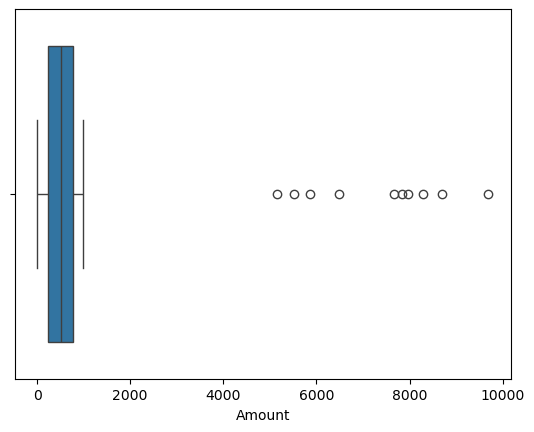

In [84]:
sns.boxplot(x=df1['Amount'])
plt.show()

- Outliers on Amount

<Axes: xlabel='CardHolderAge'>

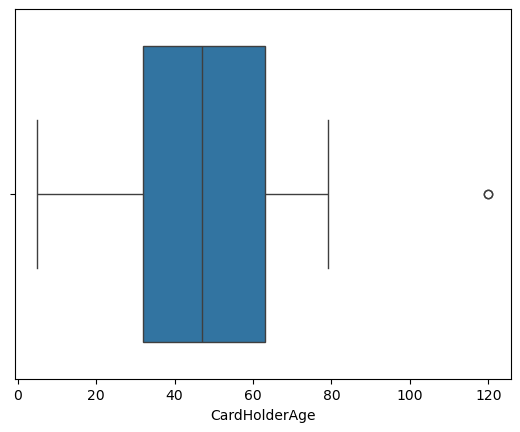

In [85]:
sns.boxplot(x=df1['CardHolderAge'])

- 1 outliers are showing

<Axes: xlabel='TimeDiff'>

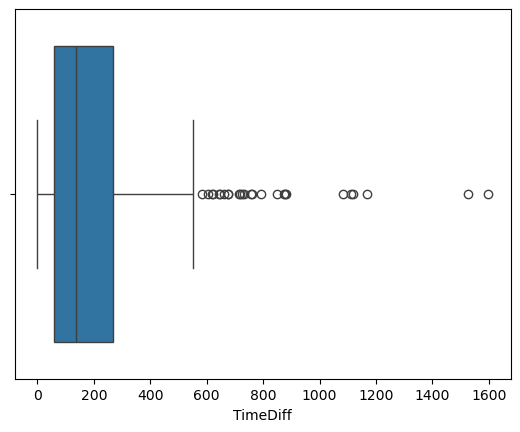

In [86]:
sns.boxplot(x=df1['TimeDiff'])

In [87]:
df1['Location'].value_counts()

Location
Miami          97
Chicago        94
Los Angeles    89
New York       78
Houston        74
Name: count, dtype: int64

In [88]:
df1['MerchantCategory'].value_counts()

MerchantCategory
Entertainment    96
Groceries        92
Electronics      91
Travel           85
Clothing         68
Name: count, dtype: int64

In [89]:
colsforoutliers=['Amount','CardHolderAge','TimeDiff']
def iqr_capping(x):
    Q1=x.quantile(0.25)
    Q3=x.quantile(0.75)
    IQR=Q3-Q1
    lower=(Q1-1.5*IQR)
    upper=(Q3+1.5*IQR)
    return x.clip(lower,upper)

df1[colsforoutliers]=df1[colsforoutliers].apply(iqr_capping)

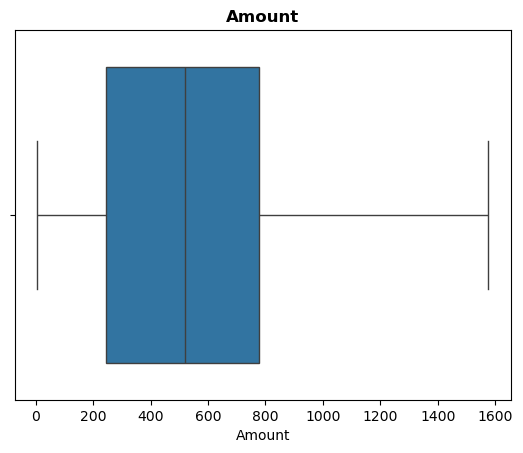

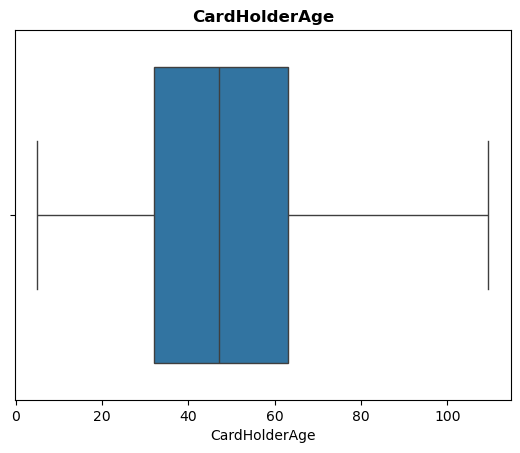

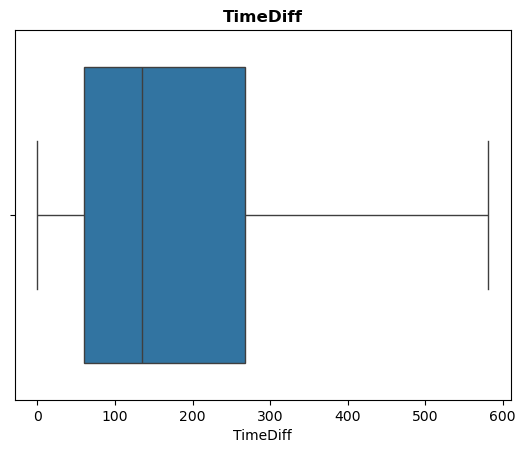

In [90]:
for i in colsforoutliers:
    sns.boxplot(x=df1[i])
    plt.title(i,fontweight='bold')
    plt.show()

In [91]:
# apply one hot encode for categorical variables
df1=pd.get_dummies(df1,columns=['Location','MerchantCategory'], drop_first=True)
df1.head()

,Amount,CardHolderAge,IsFraud,Hour,TimeDiff,Location_Houston,Location_Los Angeles,Location_Miami,Location_New York,MerchantCategory_Electronics,MerchantCategory_Entertainment,MerchantCategory_Groceries,MerchantCategory_Travel
169,591.30,19.0,0,0,0.0,False,False,True,False,True,False,False,False
309,271.56,25.0,0,0,22.0,False,True,False,False,False,False,False,True
247,966.69,76.0,0,0,40.0,True,False,False,False,False,False,False,True
290,31.47,68.0,1,0,118.0,False,False,False,False,False,True,False,False
167,187.33,79.0,0,0,67.0,True,False,False,False,False,False,False,False


In [92]:
# Scaling the numeric variable
scaler=StandardScaler()
scaled_cols=['Amount','CardHolderAge', 'Hour', 'TimeDiff']
df1[scaled_cols]=scaler.fit_transform(df1[scaled_cols])

In [93]:
# split the data into training and testing set
x=df1.drop(columns=['IsFraud'])
y=df1['IsFraud']
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.3,random_state=42,stratify=y)
# Check the new split sizes
print("Training set size:", x_train.shape)
print("Test set size:", x_test.shape)

Training set size: (302, 12)
Test set size: (130, 12)


In [94]:
# Apply SMOTE only on training set
smote = SMOTE(random_state=42)
x_train_smote, y_train_smote = smote.fit_resample(x_train, y_train)

In [95]:
print("Before SMOTE:", Counter(y_train))
print("After SMOTE:", Counter(y_train_smote))

Before SMOTE: Counter({0: 286, 1: 16})
After SMOTE: Counter({0: 286, 1: 286})


In [96]:
# Define models with some parameters
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000), 
    "Random Forest Classifier": RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42),
    "Decision Tree Classifier": DecisionTreeClassifier(max_depth=5, random_state=42),
    "KNeighbors Classifier": KNeighborsClassifier(n_neighbors=5),
    "SVM": SVC(kernel='rbf', C=1.0,probability=True),  # rbf for non liner data
    "Bagging Classifier": BaggingClassifier(n_estimators=50, random_state=42),
    "Ada Boost Classifier": AdaBoostClassifier(n_estimators=100, learning_rate=0.5, random_state=42)
}

In [99]:
threshold = 0.2
s_results=[]
for name, model in models.items():
    print(f"\n{name}")
    print("-"*len(name))
    model.fit(x_train_smote,y_train_smote)
    y_proba = model.predict_proba(x_test)[:,1]
    y_pred=(y_proba>=threshold).astype(int)  # Apply threshold

    # Accuracy
    acc=accuracy_score(y_test,y_pred)
    s_results.append({"Model":name,"Accuracy":acc})
    print(f"Accuracy: {acc:.2f}")

    # Confusion Matrix
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    
    # Classification Report
    print("Classification Report:")
    print(classification_report(y_test, y_pred))


Logistic Regression
-------------------
Accuracy: 0.55
Confusion Matrix:
[[67 56]
 [ 2  5]]
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.54      0.70       123
           1       0.08      0.71      0.15         7

    accuracy                           0.55       130
   macro avg       0.53      0.63      0.42       130
weighted avg       0.92      0.55      0.67       130


Random Forest Classifier
------------------------
Accuracy: 0.63
Confusion Matrix:
[[80 43]
 [ 5  2]]
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.65      0.77       123
           1       0.04      0.29      0.08         7

    accuracy                           0.63       130
   macro avg       0.49      0.47      0.42       130
weighted avg       0.89      0.63      0.73       130


Decision Tree Classifier
------------------------
Accuracy: 0.48
Confusion Matrix:
[[57 66]
 [ 1  6]]
C

In [100]:
# convert result to dataframe
smote_result=pd.DataFrame(s_results)
print("Summary of Accuracies:")
smote_result=smote_result.sort_values(by="Accuracy",ascending=False)
smote_result

Summary of Accuracies:


,Model,Accuracy
4,SVM,0.861538
5,Bagging Classifier,0.661538
1,Random Forest Classifier,0.630769
3,KNeighbors Classifier,0.561538
0,Logistic Regression,0.553846
2,Decision Tree Classifier,0.484615
6,Ada Boost Classifier,0.061538


### Note
IsFraud variable is highly imbalanced. Even after using SMOTE to balance the training data and applying a lower classification threshold to catch more frauds, the models still show low precision and fluctuating recall for fraud in the test set.

**This happens because:**  
1. The test set remains imbalanced, so the few fraud cases have a large effect on metrics.
2. Thresholding helps increase fraud detection (recall) but can decrease overall accuracy and increase false positives.
3. Some models (SVM, ensemble methods) may not produce high enough probabilities for fraud, so thresholding has little effect.